In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import random
from torch.utils.data import Dataset, DataLoader
import pandas as pd

print(torch.__version__)

2.2.1+cu121


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
finaldata = pd.read_csv("/content/drive/MyDrive/capstone_yb/Voting ML/DATA/merged_INB.csv")
finaldata.head()

In [ ]:
# County 열을 할당
county_info = finaldata['Geographic Area Name']

# I need Colum 'county'
finaldata['County'] = county_info.apply(lambda x: x.split(',')[1].replace('County', '').strip().upper())
print(finaldata['County'])


0         ADAMS
1         ADAMS
2         ADAMS
3         ADAMS
4         ADAMS
          ...  
58957    YAKIMA
58958    YAKIMA
58959    YAKIMA
58960    YAKIMA
58961    YAKIMA
Name: County, Length: 58962, dtype: object


In [ ]:
finaldata.replace('Nan', float('nan'), inplace=True)
finaldata.replace('-', float('nan'), inplace=True)
finaldata = finaldata.dropna()
finaldata.to_csv('/content/drive/MyDrive/capstone_yb/Voting ML/DATA/cleaned_finaldata.csv', index=False)

In [ ]:
print(finaldata.columns)

Index(['Geography', 'Geographic Area Name',
       'Estimate!!Households!!Median income (dollars)',
       'Estimate!!Families!!Median income (dollars)',
       'Estimate!!Married-couple families!!Median income (dollars)',
       'Estimate!!Nonfamily households!!Median income (dollars)',
       'House Hold Less than $50,000', 'House Hold $50,000 to $99,999',
       'House Hold $100,000 to $149,999', 'House Hold $150,000 to $199,999',
       'House Hold $200,000 or more', 'Families Less than $50,000',
       'Families $50,000 to $99,999', 'Families $100,000 to 149,999',
       'Families $150,000 to $199,999', 'Families $200,000 or more',
       'Married-couple Families Less than $50,000',
       'Married-couple Families $50,000 to $99,999',
       'Married-couple Families $100,000 to 149,999',
       'Married-couple Families $150,000 to $199,999',
       'Married-couple Families $200,000 or more',
       'Nonfamily households Less than $50,000',
       'Nonfamily households $50,000 to $

In [ ]:
# 데이터프레임에서 문자열이 포함된 열 찾기
str_columns = finaldata.select_dtypes(include=['object']).columns
print("StRING:", str_columns)

StRING: Index(['Geography', 'Geographic Area Name',
       'Estimate!!Households!!Median income (dollars)',
       'Estimate!!Families!!Median income (dollars)',
       'Estimate!!Married-couple families!!Median income (dollars)',
       'Estimate!!Nonfamily households!!Median income (dollars)', 'Precinct',
       'County'],
      dtype='object')


In [ ]:
X = finaldata.drop(columns=['Geography', 'Geographic Area Name','Biden_proportion','Estimate!!Households!!Median income (dollars)','Vote Count', 'Precinct','County',
                            'Estimate!!Families!!Median income (dollars)','Estimate!!Nonfamily households!!Median income (dollars)', 'Estimate!!Married-couple families!!Median income (dollars)'])
X = X.astype(float)
X.dtypes

House Hold Less than $50,000                    float64
House Hold $50,000 to $99,999                   float64
House Hold $100,000 to $149,999                 float64
House Hold $150,000 to $199,999                 float64
House Hold $200,000 or more                     float64
Families Less than $50,000                      float64
Families $50,000 to $99,999                     float64
Families $100,000 to 149,999                    float64
Families $150,000 to $199,999                   float64
Families $200,000 or more                       float64
Married-couple Families Less than $50,000       float64
Married-couple Families $50,000 to $99,999      float64
Married-couple Families $100,000 to 149,999     float64
Married-couple Families $150,000 to $199,999    float64
Married-couple Families $200,000 or more        float64
Nonfamily households Less than $50,000          float64
Nonfamily households $50,000 to $99,999         float64
Nonfamily households $100,000 to 149,999        

In [ ]:
y = finaldata['Biden_proportion']
y.dtype

dtype('float64')

In [ ]:
import copy
import numpy as np
import tqdm
from sklearn.model_selection import train_test_split

# train-test split of the dataset / chaning split of data to Pytorch
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)
X_train = torch.tensor(X_train.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test.values, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32).reshape(-1, 1)


In [ ]:
print(X_train.shape)
print(y_train.shape)

#1517*70% train = 1061

torch.Size([36754, 20])
torch.Size([36754, 1])


In [ ]:
# Define the neural network class
class SimpleNN(nn.Module):
    def __init__(self): #MLP 두개 선형 레이어로 구성된 단순 다층 퍼셉트론
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(20, 32)
        self.fc2 = nn.Linear(32, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Hyperparameters
input_size = 20
hidden_size = 32
output_size = 1

# Instantiate the model
model = SimpleNN()


In [ ]:
county_info = finaldata['County'].unique().tolist()
len(county_info)

39

In [ ]:
class CountyDataset(Dataset): #classcification
    def __init__(self, finaldata):
        f =  finaldata.drop(columns=['Geography', 'Geographic Area Name','Biden_proportion','Estimate!!Households!!Median income (dollars)','Vote Count', 'Precinct','County',
                            'Estimate!!Families!!Median income (dollars)','Estimate!!Nonfamily households!!Median income (dollars)', 'Estimate!!Married-couple families!!Median income (dollars)']).astype(float)
        self.X = f.values.tolist()
        self.y = finaldata['Biden_proportion'].tolist()
        self.county_info = finaldata['County'].tolist()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32), self.county_info[idx]

In [ ]:
dataset = CountyDataset(finaldata)

In [ ]:
class CountyDataLoader: #load the data with county
    def __init__(self, dataset, random_state=None):
        self.dataset = dataset
        self.counties = list(set(dataset.county_info))
        self.random_state = random_state

    def __iter__(self): #load the data with each county
        for county in self.counties:
            county_indices = [i for i, c in enumerate(self.dataset.county_info) if c == county]
            batch_X = [self.dataset.X[i] for i in county_indices]
            batch_y = [self.dataset.y[i] for i in county_indices]
            yield batch_X, batch_y


In [ ]:
county_dataloader = CountyDataLoader(dataset)

In [ ]:
# Define the custom loss function
def custom_loss(predictions, county_statistics):
    # Calculate the average prediction within the batch
    avg_prediction = torch.mean(predictions)

    # Assume county_statistics is a tuple containing the required statistics (e.g., Biden proportion)
    biden_proportion = county_statistics[0]

    # Calculate the MSE loss 평균 제곱 오차(Mean Squared Error)
    mse_loss = nn.MSELoss()(avg_prediction, biden_proportion)

    return mse_loss

In [ ]:
# Define the loss function
class LossFunction(nn.Module):
    def __init__(self):
        super(LossFunction, self).__init__()

    def forward(self, predictions, mean_l): #calculate MSE
        mean_p = torch.mean(predictions)
        mean_l = torch.tensor(mean_l, dtype=torch.float32)

        return torch.square(mean_p - mean_l)

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
import torch
num_epochs = 500
losses = []
for epoch in range(num_epochs):
    for i,(train_X, train_y)  in enumerate(county_dataloader):
      epoch_loss = 0.0
      if i<32:

        # Convert lists to PyTorch tensors
        features = torch.tensor(train_X)
        target = torch.tensor(train_y)

        # Forward pass, loss computation, and backward pass
        outputs = model(features)
        # print(outputs) # issue here
        loss = custom_loss(outputs, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        average_epoch_loss = epoch_loss /50
       # losses.append(loss.item())
        losses.append(average_epoch_loss)

    if epoch % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')

Epoch [1/500], Loss: 0.03378956392407417
Epoch [11/500], Loss: 0.00730674434453249
Epoch [21/500], Loss: 0.0035126390866935253
Epoch [31/500], Loss: 0.0014085593866184354
Epoch [41/500], Loss: 0.00047973523032851517
Epoch [51/500], Loss: 4.964925392414443e-05
Epoch [61/500], Loss: 5.413423787103966e-05
Epoch [71/500], Loss: 0.0002961371501442045
Epoch [81/500], Loss: 0.0006622913060709834
Epoch [91/500], Loss: 0.0008838777430355549
Epoch [101/500], Loss: 0.0013274577213451266
Epoch [111/500], Loss: 0.001764520420692861
Epoch [121/500], Loss: 0.0021160661708563566
Epoch [131/500], Loss: 0.002431725850328803
Epoch [141/500], Loss: 0.0026350473053753376
Epoch [151/500], Loss: 0.002826893236488104
Epoch [161/500], Loss: 0.003102656453847885
Epoch [171/500], Loss: 0.0033903908915817738
Epoch [181/500], Loss: 0.003557276912033558
Epoch [191/500], Loss: 0.003844248363748193
Epoch [201/500], Loss: 0.004061801824718714
Epoch [211/500], Loss: 0.004320523701608181
Epoch [221/500], Loss: 0.0046452

The given output indicates that the model's training loss is decreasing, which is a positive sign indicating that the model is learning from the data. The decreasing loss signifies that the model is making better predictions over time.

In the initial few epochs, the loss decreases significantly. This is because initially, the model is making large improvements in reducing errors as it learns. However, as the training progresses, the rate of decrease in loss slows down. This is because the model is becoming better adapted to the data and approaching the optimal solution.

In the last epochs, the loss is almost unchanged. This could indicate that the model has either learned from the data completely or there is little room for further improvement. Thus, training could be stopped at this point.

Overall, the model is learning, and the decreasing loss indicates that the training is proceeding well.

Additionally, during the training process, especially in the early epochs, it is common for the loss to decrease rapidly. Later on, the rate of loss decrease gradually diminishes as the model converges towards the optimal solution. It's important to note that once the loss reaches a certain level, training should be stopped to prevent the model from overfitting the data and to improve generalization performance.








In [ ]:
import matplotlib.pyplot as plt

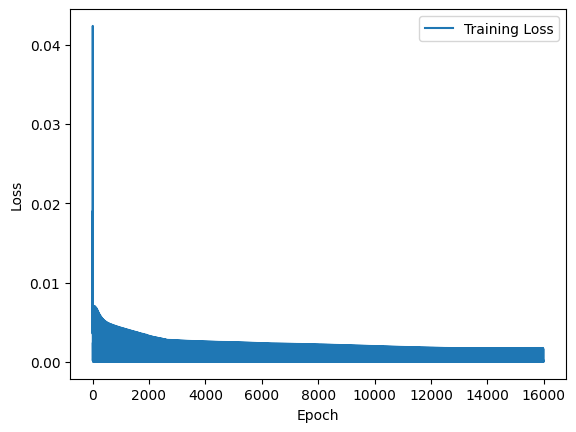

In [ ]:
plt.plot(losses[10:], label='Training Loss') #The code plots only the data points for the training loss after excluding the first 10 epochs.
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
model.eval()

SimpleNN(
  (fc1): Linear(in_features=20, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
)

In [ ]:
import numpy as np
import time

rmse_total = 0
num_batches = 0
losses = []
timestamps = []
epoch_test_loss = 0.0

for i, (val_X, val_y) in enumerate(county_dataloader):
    if i >= 32:
        start_time = time.time()
        var = 0.0

        features = torch.tensor(val_X)
        target = torch.tensor(val_y)

        outputs = model(features)
        loss = custom_loss(outputs, target)

        rmse_total += loss.item()
        var += loss.item()
        avg = var / 12
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        num_batches += 1
        end_time = time.time()
        losses.append(avg)
        timestamps.append(end_time - start_time)

average_rmse = np.sqrt(rmse_total / max(num_batches, 1))

print(f'Average RMSE: {average_rmse, num_batches}')


Average RMSE: (0.27092237316695306, 7)


Text(0.5, 1.0, 'Loss Versus Time for Test Data')

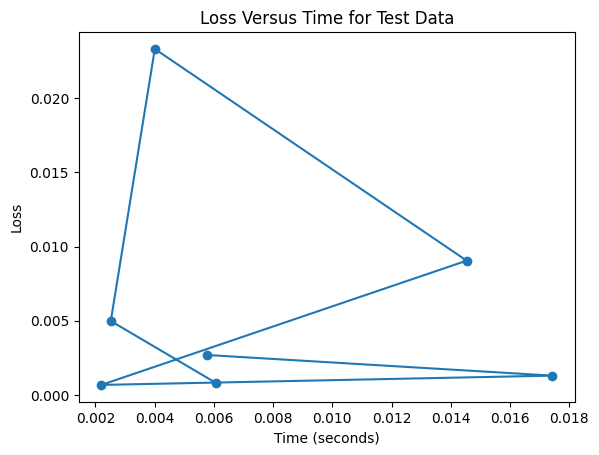

In [ ]:
# Plotting the loss versus time for both training and test data
plt.plot(timestamps, losses, marker='o')
plt.xlabel('Time (seconds)')
plt.ylabel('Loss')
plt.title('Loss Versus Time for Test Data')


Evaluation

In [ ]:
overlapping_matching_avg_biden = pd.read_csv("/content/drive/MyDrive/capstone_yb/Voting ML/DATA/overlapping_matching_avg_biden.csv")
overlapping_matching_avg_biden

,Unnamed: 0,Geographic Area Name,Biden_proportion,average_Biden_proportion
0,0,"Census Tract 1,Whitman County, Washington",[0.88311688 0.8238342 0.77192982 0.78448276 0...,0.802316
1,1,"Census Tract 1,Yakima County, Washington",[0.64173228 0.61656442],0.629148
2,2,"Census Tract 1.01,King County, Washington",[0.86743516 0.8853211 0.9 ],0.884252
3,3,"Census Tract 1.01,Whatcom County, Washington",[0.51206434 0.41312741 0.74137931 0.4 0...,0.461398
4,4,"Census Tract 1.02,King County, Washington",[0.85224839 0.84982935 0.88797364 0.91312384 0...,0.857644
...,...,...,...,...
1740,1740,"Census Tract 98.01,King County, Washington",[0.86824324 0.90571429 0.88934426 0.81589958 0...,0.884990
1741,1741,"Census Tract 98.02,King County, Washington",[0.88536585 0.90909091 0.89920424 0.87790698 0...,0.882116
1742,1742,"Census Tract 9800,Cowlitz County, Washington",[0.46586826 nan],NaN
1743,1743,"Census Tract 9801,Franklin County, Washington",[0.32517483],0.325175


In [ ]:
overlapping_matching_avg_biden['Geographic Area Name'] = overlapping_matching_avg_biden['Geographic Area Name'].str.replace(' ', '')


In [ ]:
evaluation_df = finaldata.drop('Biden_proportion', axis =1)
evaluation_df['Geographic Area Name'] = evaluation_df['Geographic Area Name'].str.replace(' ', '')


In [ ]:
ㅊ

,Geography,Geographic Area Name,Estimate!!Households!!Median income (dollars),Estimate!!Families!!Median income (dollars),Estimate!!Married-couple families!!Median income (dollars),Estimate!!Nonfamily households!!Median income (dollars),"House Hold Less than $50,000","House Hold $50,000 to $99,999","House Hold $100,000 to $149,999","House Hold $150,000 to $199,999",...,"Married-couple Families $200,000 or more","Nonfamily households Less than $50,000","Nonfamily households $50,000 to $99,999","Nonfamily households $100,000 to 149,999","Nonfamily households $150,000 to $199,999","Nonfamily households $200,000 or more",Vote Count,Precinct,County,average_Biden_proportion
0,1400000US53001950100,"CensusTract9501,AdamsCounty,Washington",52589,70244,73250,27684,48.2,31.5,11.5,8.2,...,1.5,69.6,18.8,2.9,8.8,0.0,15611,BATUM,ADAMS,0.227982
1,1400000US53001950100,"CensusTract9501,AdamsCounty,Washington",52589,70244,73250,27684,48.2,31.5,11.5,8.2,...,1.5,69.6,18.8,2.9,8.8,0.0,15612,BATUM,ADAMS,0.227982
2,1400000US53001950100,"CensusTract9501,AdamsCounty,Washington",52589,70244,73250,27684,48.2,31.5,11.5,8.2,...,1.5,69.6,18.8,2.9,8.8,0.0,15613,BATUM,ADAMS,0.227982
3,1400000US53001950100,"CensusTract9501,AdamsCounty,Washington",52589,70244,73250,27684,48.2,31.5,11.5,8.2,...,1.5,69.6,18.8,2.9,8.8,0.0,15614,BATUM,ADAMS,0.227982
4,1400000US53001950100,"CensusTract9501,AdamsCounty,Washington",52589,70244,73250,27684,48.2,31.5,11.5,8.2,...,1.5,69.6,18.8,2.9,8.8,0.0,15615,BATUM,ADAMS,0.227982
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52501,1400000US53077940007,"CensusTract9400.07,YakimaCounty,Washington",43721,43924,46533,21851,58.2,29.0,8.1,2.5,...,0.0,68.1,27.4,4.6,0.0,0.0,24159,2501,YAKIMA,0.809287
52502,1400000US53077940007,"CensusTract9400.07,YakimaCounty,Washington",43721,43924,46533,21851,58.2,29.0,8.1,2.5,...,0.0,68.1,27.4,4.6,0.0,0.0,24160,2501,YAKIMA,0.809287
52503,1400000US53077940007,"CensusTract9400.07,YakimaCounty,Washington",43721,43924,46533,21851,58.2,29.0,8.1,2.5,...,0.0,68.1,27.4,4.6,0.0,0.0,24161,2501,YAKIMA,0.809287
52504,1400000US53077940008,"CensusTract9400.08,YakimaCounty,Washington",43135,44098,46125,13650,61.5,23.0,10.0,3.9,...,0.0,90.4,9.6,0.0,0.0,0.0,24162,2502,YAKIMA,0.846154


In [ ]:
merged_df.replace('-', float('nan'), inplace=True)
merged_df = merged_df.dropna()
merged_df

# CSV 파일로 저장
merged_df.to_csv("/content/drive/MyDrive/processed_data.csv", index=False)

<ipython-input-17-cb6034fea95c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df.replace('-', float('nan'), inplace=True)


In [ ]:
class CountyDataset2(Dataset):
    def __init__(self, finaldata):
        f =  finaldata.drop(columns=['Geography', 'Geographic Area Name','Precinct','County', 'Vote Count','Estimate!!Households!!Median income (dollars)','average_Biden_proportion',
                            'Estimate!!Families!!Median income (dollars)','Estimate!!Nonfamily households!!Median income (dollars)', 'Estimate!!Married-couple families!!Median income (dollars)']).astype(float)
        self.X = f.values.tolist()
        self.y = finaldata['average_Biden_proportion'].tolist()
        self.county_info = finaldata['County'].tolist()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32), self.county_info[idx]


In [ ]:
dataset_evaluation = CountyDataset2(merged_df)
county_dataloader2 = CountyDataLoader(dataset_evaluation)

In [ ]:
rmse_total = 0
num_batches = 0
losses1 = []
timestamps1 = []
for i,(val_X, val_y) in enumerate(county_dataloader2):
    var = 0.0
    start_time = time.time()


    features = torch.tensor(val_X)
    target = torch.tensor(val_y)


    outputs = model(features)
    loss = custom_loss(outputs, target)

    rmse_total += loss.item()
    var += loss.item()
    avg = var/62
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    end_time = time.time()

    num_batches += 1
    losses1.append(avg)
    timestamps1.append(end_time - start_time)

average_rmse = np.sqrt(rmse_total / num_batches)

print(f'Average RMSE: {average_rmse,num_batches }')

Average RMSE: (0.17563571724326635, 38)


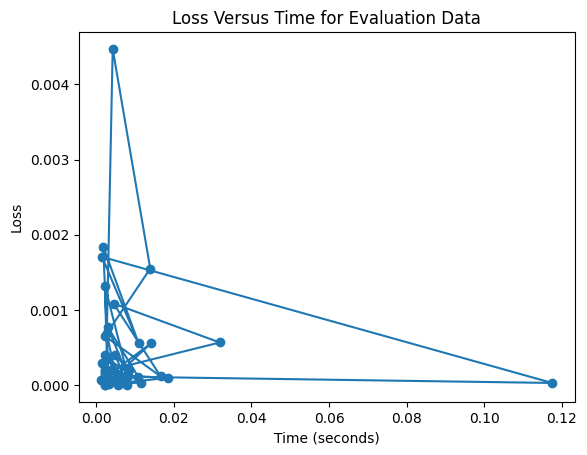

In [ ]:
# Plotting the loss versus time
plt.plot(timestamps1, losses1, marker='o')
plt.xlabel('Time (seconds)')
plt.ylabel('Loss')
plt.title('Loss Versus Time for Evaluation Data')
plt.show()